<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/PraktikumPhysik/NormalVerteilungMunzeWerfen.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# SIMPSON Template
Simple template for creating a SIMPSON script, running it, and plotting the results using Jupyter notebooks

In [ ]:
#Setup for Google Colab
import sys
if 'google.colab' in sys.modules:
    from urllib.request import urlretrieve
    import os
    url="https://inano.au.dk/fileadmin/user_upload/Simpson_Setup_Linux_4.2.1.tbz2"
    filename=os.path.split(url)[1]
    out=urlretrieve(url, filename)
    !tar xf Simpson_Setup_Linux_4.2.1.tbz2
    !cd Simpson
    !./install.sh
    !cd ..

In [64]:
# Imports
from subprocess import Popen, PIPE
import numpy as np
import matplotlib.pyplot as plt

In [79]:
script="""
spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 10 20 30
  shift    1 10p 1p 0.5 50 20 10
}

par {
  variable index   1

  np               128
  spin_rate        10000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I1p
  method           direct
  crystal_file     rep144
  gamma_angles     100
  sw               spin_rate/2
  variable tsw     1e6/sw
  verbose          1101
  variable rfF1    75000
  variable rfF2    50000
  variable t180F1  0.5e6/rfF1
  variable t180F2  0.5e6/rfF2
  variable Del_t180 0.5*(t180F2-t180F1)     
  variable tr2     0.5e6/spin_rate-t180F2
  variable tr1     0.5e6/spin_rate-0.5*t180F2
}

proc pulseq {} {
  global par
  store 4
  store 5

  reset
  delay $par(tr2)
  pulse $par(t180F2) 0 x $par(rfF2) x
  delay $par(tr2)
  pulse $par(t180F2) 0 x $par(rfF2) y
  store 1

  reset
  pulse $par(t180F2) 0 x $par(rfF2) y
  delay $par(tr2)
  pulse $par(t180F2) 0 x $par(rfF2) x
  delay $par(tr2)
  store 2

  reset
  delay $par(tr1)
  pulse $par(Del_t180) 0 x $par(rfF2) x
  pulse $par(t180F1) $par(rfF1) x $par(rfF2) x
  pulse $par(Del_t180) 0 x $par(rfF2) x
  delay $par(tr1)
  store 3

  acq
  for {set i 1} {$i < $par(np)} {incr i} {
    reset
    prop 5
    prop 2
    store 5

    reset
    prop 4
    prop 1
    store 4

    prop 3
    prop 5
    acq
  }
}
proc main {} {
  global par

  set f [fsimpson]
  fsave $f $par(name).fid
}
"""

In [80]:
# Write out a file with the script above, run
with open('SIMPSON.tcl','w') as f:f.write(script)
process = Popen(['simpson', 'SIMPSON.tcl', '-d'], stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()            

In [81]:
# Collect the results
with open('SIMPSON.fid','r') as f:
    while True:
        if 'DATA'==f.readline().strip():break
    S=[]
    while True:
        line=f.readline()
        if 'END'==line.strip():break
        S.append(complex(line.strip().split()[0])+complex(line.strip().split()[1])*1j)
S=np.array(S)

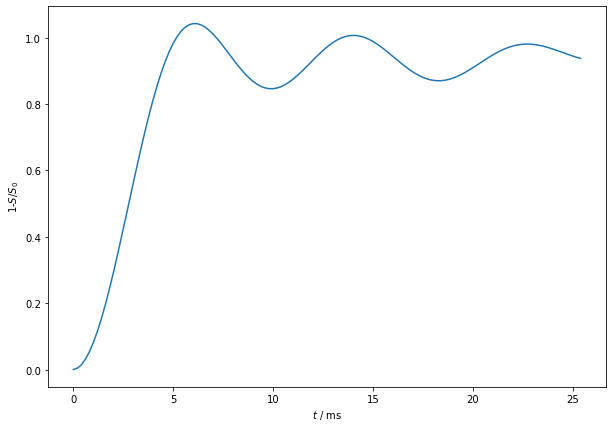

In [82]:
# Plot the results
x=2/10000*1e3*np.arange(len(S))
fig,ax=plt.subplots()
ax.plot(x,1-S.real)
ax.set_xlabel(r'$t$ / ms')
ax.set_ylabel(r'1-$S/S_0$')
fig.set_size_inches([10,7])